In [223]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost
from xgboost import XGBClassifier, XGBRegressor
# from xgboost import plot_importance # Features Importance 시각화
from sklearn.metrics import roc_auc_score
import hyperopt as hopt


import user_functions as uf


import platform

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':  # 맥OS 
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  # 윈도우
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...  sorry~~~')

# .py import 상하위폴더
# https://brownbears.tistory.com/296



In [61]:
# load
train_datasets = pd.read_csv("../pre_data/[no_up]train_datasets.csv",
                             index_col=0)

# Label 만들기
train_target_ds = train_datasets["TARGET"]
train_target_ds = train_target_ds.astype("int32")

# TARGET feature 삭제
train_datasets.drop(columns="TARGET", inplace=True)

X_train , X_test , y_train , y_test = \
    train_test_split(train_datasets, 
                     train_target_ds, 
                     test_size=0.2, 
                     random_state=2021,
                     stratify=train_target_ds
                    )

In [ ]:
# regularization candiate 정의
reg_candidate = [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 5, 10, 100]
object_f = ["reg:squaredlogerror", "binary:logistic", "multi:softprob"]
# "multi:softmax", "reg:squarederror", "rank:pairwise", "rank:ndcg", "rank:map"
s_p_w_value = \
    y_train.value_counts().values.tolist()[0] / y_train.value_counts().values.tolist()[1]

space = {"n_estimators":hopt.hp.quniform("n_estimators", 50),
         "objective": hopt.hp.choice("objective", object_f),
         "learning_rate": hopt.hp.quniform("learning_rate", 0.01, 0.1, 0.2),
         "max_depth": hopt.hp.quniform("max_depth", -1, 5, 9, 13, 17, 21),
         "min_child_weight": hopt.hp.quniform("min_child_weight", 5, 9, 13, 17, 21),
         "colsample_bytree": hopt.hp.quniform("colsample_bytree", 0.2, 0.5, 0.8, 1),
         "subsample": hopt.hp.quniform("subsample", 0.2, 0.5, 0.8, 1),
         "reg_lambda": hopt.hp.quniform("reg_lambda", 0.2, 0.5, 0.8, 1),
         "reg_alpha": hopt.hp.quniform("reg_alpha", 0.2, 0.5, 0.8, 1),
         "scale_pos_weight": hopt.hp.quniform("scale_pos_weight", 1, 5, 9, s_p_w_value),
         "base_score": hopt.hp.quniform("base_score", 0.5, 0.65, 0.8, s_p_w_value),
         "booster": hopt.hp.quniform("booster", "gbtree", "gblinear", "dart")
        }

model = XGBRegressor(n_estimators =int(space["n_estimators"]), 
                     objective=space["objective"],
                     learning_rate=float(space["learning_rate"]),
                     max_depth=int(space["max_depth"]), 
                     min_child_weight=int(space["min_child_weight"]),
                     colsample_bytree=float(space["colsample_bytree"]),
                     subsample=float(space["subsample"]),
                     reg_lambda=float(space["reg_lambda"]),
                     reg_alpha=float(space["reg_alpha"]),
                     scale_pos_weight=space["hopt.hp.quniform"],
                     base_score=float(space["base_score"]),
                     booster=space["booster"]
                    )

model.fit(X_train, y_train,
          eval_metric="auc", 
          early_stopping_rounds=50,
          eval_set=[(X_train, y_train), (X_test, y_test)],
          verbose=10, # 10개 단위로 출력
         )

print("train best     score:", format(xgb.best_score, ".4f"))
print("test   roc_auc_score:", format(roc_auc_score(y_test, xgb.predict(X_test)), ".4f"))

In [ ]:
model = XGBRegressor(n_estimators=int(space["n_estimators"]))

In [222]:
s_p_w_value = \
    y_train.value_counts().values.tolist()[0] / y_train.value_counts().values.tolist()[1]

xgb = XGBClassifier(n_estimators=100,
# xgb = XGBRegressor(n_estimators=400,
                    # 몇 회의 Step을 반복할지 지정함
                    # 너무 큰 값을 사용하면 Overfitting의 가능성이 상승하고, Model의 Size가 증가함
                    # default X => 필수로 설정해야 함.

                    objective="binary:logistic",
                    # 목적함수로 이 함수의 결과값이 최소화되는 방향으로 학습함
                    # default="reg:squarederror"
                    # reg:squarederror / reg:squaredlogerror / binary:logistic / multi:softmax / multi:softprob / rank:pairwise / rank:ndcg / rank:map

                    learning_rate=0.1,
                    # 반복적으로 부스팅 스텝을 수행할 때 업데이트되는 학습률 값
                    # n(0 ~ 1) / 과적합 조절, 낮을수록 good

                    max_depth=19,
                    # 최대 tree의 깊이로 2^N개의 leaf node가 생김
                    # n(-1 ~ inf) / default=6 / -1 = inf

                    min_child_weight=6, # 과적합 조절, 클수록 분할 자제
                    # Tree에서 가지를 나룰지 결정할 때 필요한 데이터의 weight 합

                    # nthread # default=max
                    # 학습에 사용할 thread 개수
                    
                    colsample_bytree=0.8,
                    # colsample = feature를 Sampling하는 비율
                    # feature가 많거나, 소수의 feature에 의존적일 때 사용하여 과적합 조절
                    # _bytree: 각 Tree(Step) 마다 사용할 Feature의 비율
                    # _bynode: 각 node의 depth 마다 사용할 Feature의 비율
                    # _bylevel: 각 Tree의 depth 마다 사용할 Feature의 비율
                    # n(0 ~ 1) / default=1

                    subsample=0.8,
                    # Tree가 커져서 과적합을 방지하기 위해 데이터를 Sampling하는 비율
                    # n(0 ~ 1) / default=1
                    
                    reg_lambda=30.930,
                    # L2 Regularization parameter
                    # feature의 개수가 많을 경우 적용을 검토함
                    # 너무 큰 가중치를 그 크기에 비례하여 줄임
                    # 커질수록 overfitting의 방지하나, 너무 크면 underfitting 발생
                    # n(0 ~ inf) / default=1

                    reg_alpha=30.564,
                    # L1 Regularization parameter
                    # feature의 개수가 많을 경우 적용을 검토함
                    # 커질수록 overfitting의 방지하나, 너무 크면 underfitting 발생
                    # 불필요한 가중치를 0으로 만듦
                    # n(0 ~ inf) / default=0

                    scale_pos_weight=s_p_w_value,
                    # 특정 값으로 편향된 불균형한 datasets의 가중치를 조절
                    # 권장값 = sum(negative instances) / sum(positive instances)
                    # default=1

                    # verbosity=2,
                    # Verbosity of printing messages.
                    # Valid values are 0 (silent), 1 (warning), 2 (info), 3 (debug)
                    # default=1

                    # base_score=0.8,
                    # 초기 편향값(Bias) 시작하는 위치
                    # default=0.5

                    # Error 떠서 쓰는 것
                    use_label_encoder=False,

                    booster="dart"
                    # gbtree / gblinear / dart
                    # default="gbtree"
                    )

xgb.fit(X_train, y_train,
        eval_metric="auc", 
        # 각 Step마다 완성된 모델의 평가 지표
        # rmse, emsle, mae, error, error@t, merror, auc, aucpr ...

        early_stopping_rounds=50,
        # eval_metric의 결과가 early_stopping_rounds 횟수 동안 개선되지 않으면, n_estimator(num_boost_round)에 도달하기 전에 종료함.
        # n(0 ~ inf) / default=None(비활성화)

        eval_set=[(X_train, y_train), (X_test, y_test)],

        # 실행 과정 출력 여부
        # verbose=False, # True: 모두 출력, False: 출력 생략
        verbose=10, # 10개 단위로 출력
       )

[0]	validation_0-auc:0.70181
[10]	validation_0-auc:0.74158
[20]	validation_0-auc:0.75010
[30]	validation_0-auc:0.75454
[40]	validation_0-auc:0.75692
[50]	validation_0-auc:0.75689
[60]	validation_0-auc:0.75738
[70]	validation_0-auc:0.75704
[80]	validation_0-auc:0.75750
[90]	validation_0-auc:0.75739
[99]	validation_0-auc:0.75726


XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=19,
              min_child_weight=6, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=30.564, reg_lambda=30.93,
              scale_pos_weight=11.419527896995708, subsample=0.8,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [221]:
# print(xgb.evals_result())
print("train best     score:", format(xgb.best_score, ".4f"))
print("train best iteration:", format(xgb.best_iteration, ".3f"))

# .predict_proba: label값이 주어졌을 때 Target 값으로 분류될 확률
# 이진분류이므로 0, 1이고, ndim 2를 배열하므로 [y, x] 순서로 y는 0으로 분류될 확률, x는 1로 분류될 확률을 의미함
# 따라서 위 모델에서는 연체로(1)로 분류될 확률을 의미한다.

print("test   roc_auc_score:", format(roc_auc_score(y_test, xgb.predict(X_test)), ".4f"))
# for i in np.arange(0, 1, 0.1):
#     pred = [1 if x > i else 0 for x in xgb.predict_proba(X_test)[:, 1]]
    # print("{:.1f}: {:.4f}".format(i, roc_auc_score(y_test, pred)))

# pd.DataFrame(xgb.predict_proba(X_test)[:, 1]).hist()

train best     score: 0.7491
train best iteration: 90.000
test   roc_auc_score: 0.6086


```python
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.613, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=6, missing=nan, monotone_constraints='()',
              n_estimator=400, n_estimators=100, n_jobs=4, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_aplha=3.564, reg_lambda=4.93,
              scale_pos_weight=11.419527896995708, subsample=0.708,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)
# 0.7002

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_boost_round=400,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)
# 0.5147

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.613, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=6, missing=nan, monotone_constraints='()',
              n_estimators=400, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=3.564, reg_lambda=4.93, scale_pos_weight=1,
              subsample=0.8, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)
# 0.5157

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.613, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=6, missing=nan, monotone_constraints='()',
              n_estimators=400, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=3.564, reg_lambda=4.93,
              scale_pos_weight=11.419527896995708, subsample=0.8,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)
# 0.6980

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.613, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=6, missing=nan, monotone_constraints='()',
             n_estimators=400, n_jobs=4, num_parallel_tree=1,
             objective='binary:logistic', random_state=0, reg_alpha=3.564,
             reg_lambda=4.93, scale_pos_weight=11.419527896995708,
             subsample=0.8, tree_method='exact', use_label_encoder=False,
             validate_parameters=1, verbosity=None)
# 0.7662

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.613, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=9,
             min_child_weight=6, missing=nan, monotone_constraints='()',
             n_estimators=400, n_jobs=4, num_parallel_tree=1,
             objective='binary:logistic', random_state=0, reg_alpha=3.564,
             reg_lambda=4.93, scale_pos_weight=11.419527896995708,
             subsample=0.8, tree_method='exact', use_label_encoder=False,
             validate_parameters=1, verbosity=None)
# 0.7622

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.613, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=9,
             min_child_weight=6, missing=nan, monotone_constraints='()',
             n_estimators=400, n_jobs=4, num_parallel_tree=1,
             objective='binary:logistic', random_state=0, reg_alpha=1.564,
             reg_lambda=1.93, scale_pos_weight=11.419527896995708,
             subsample=0.8, tree_method='exact', use_label_encoder=False,
             validate_parameters=1, verbosity=None)
# 0.7596

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.613, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=9,
             min_child_weight=6, missing=nan, monotone_constraints='()',
             n_estimators=400, n_jobs=4, num_parallel_tree=1,
             objective='binary:logistic', random_state=0, reg_alpha=10.564,
             reg_lambda=10.93, scale_pos_weight=11.419527896995708,
             subsample=0.8, tree_method='exact', use_label_encoder=False,
             validate_parameters=1, verbosity=None)
# 0.7637

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=19,
              min_child_weight=6, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=10.564, reg_lambda=1,
              scale_pos_weight=11.419527896995708, subsample=0.8,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)
# train best     score: 0.7491
# train best iteration: 90.000
# test   roc_auc_score: 0.6086

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.613, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=9,
              min_child_weight=4, missing=None, n_estimators=2000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=3.564, reg_lambda=4.93, scale_pos_weight=2, seed=None,
              silent=None, subsample=0.8, use_label_encoder=False, verbosity=1)
# train best score: 0.7693
# train best iteration: 1694
# test roc_auc_score: 0.5473
```

In [ ]:
# # XGBoost 모델의 예측 성능 평가
# # 수정된 get_clf_eval() 함수 
# def get_clf_eval(y_test, pred=None, pred_proba=None):
#     from sklearn.metrics import confusion_matrix, accuracy_score
#     from sklearn.metrics import precision_score, recall_score
#     from sklearn.metrics import f1_score, roc_auc_score
    
#     confusion = confusion_matrix( y_test, pred)
#     accuracy = accuracy_score(y_test , pred)
#     precision = precision_score(y_test , pred)
#     recall = recall_score(y_test , pred)
#     f1 = f1_score(y_test,pred)
#     # ROC-AUC 추가 
#     roc_auc = roc_auc_score(y_test, pred_proba)
#     print('오차 행렬')
#     print(confusion)
#     # ROC-AUC print 추가
#     print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
#     F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

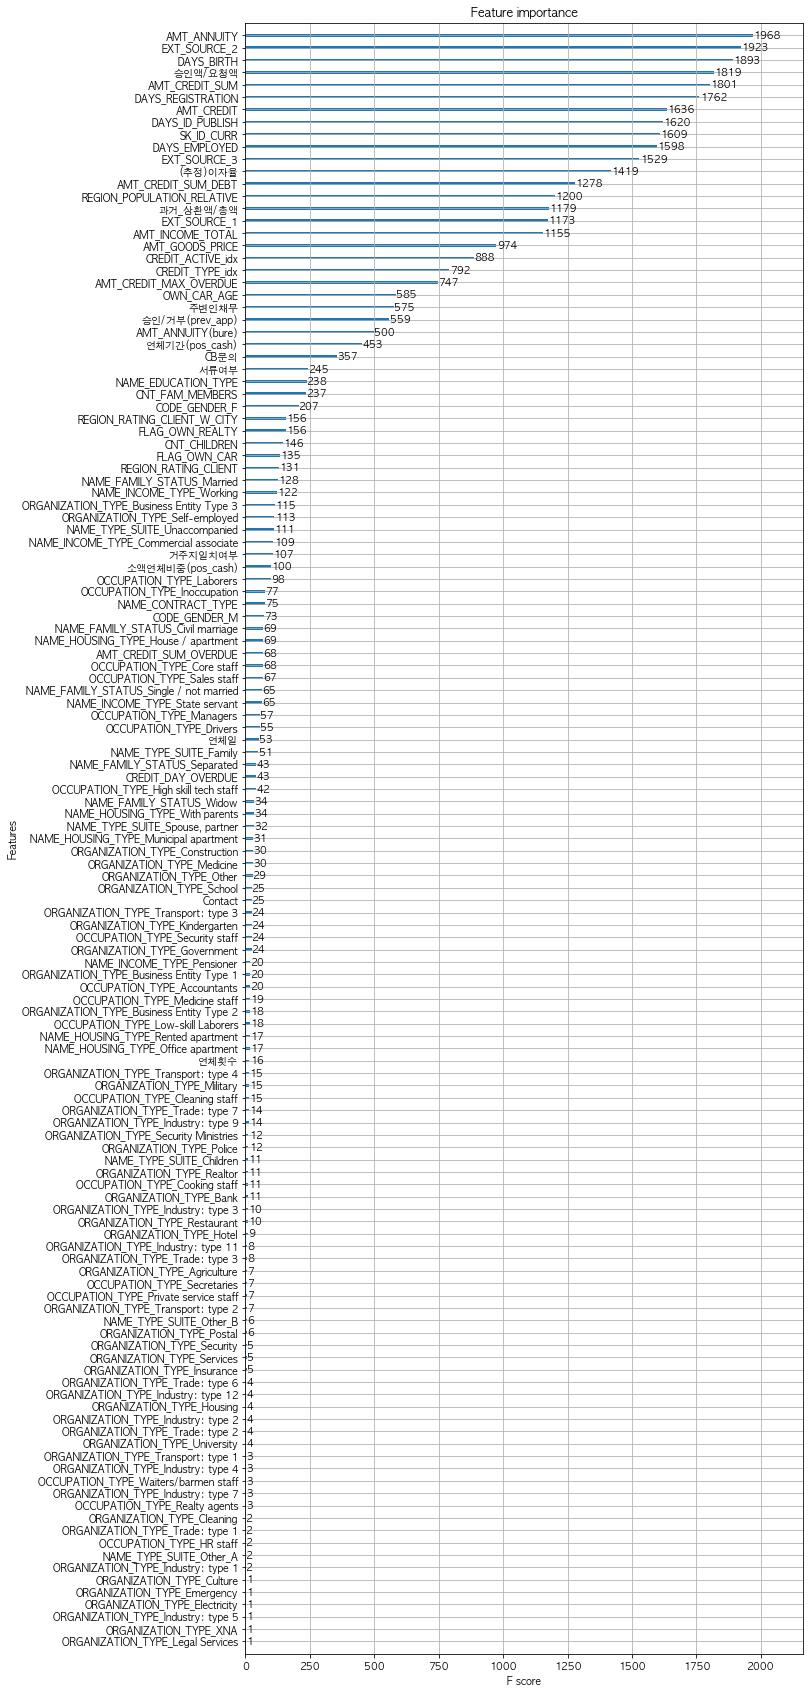

In [205]:
fig, ax = plt.subplots(figsize=(10, 30))
xgboost.plot_importance(xgb, ax=ax)

In [ ]:
# y_train.value_counts()
# TARGET
# 0.0       223503
# 1.0        19572
# dtype: int64

# y_train.value_counts()
# TARGET
# 0.0       223503
# 1.0        19572
# dtype: int64

In [ ]:
# nthread=4,
# n_estimators=2000,
# learning_rate=0.02,
# max_depth = 11,
# num_leaves=58,
# colsample_bytree=0.613,
# subsample=0.708,
# max_bin=407, # Only used if tree_method is set to hist or gpu_hist.
# reg_alpha=3.564,
# reg_lambda=4.930,
# min_child_weight= 6,
# min_child_samples=165,
# silent=-1,
# verbose=-1,


# clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'auc', verbose= 100,  early_stopping_rounds= 200)

In [59]:
# # 다중공선성 제거
# # https://john-analyst.medium.com/캐글-home-credit-default-risk-9225050b6fa6

# corrs = train_datasets.iloc[:, 1:].corr()

# above_feature = {}

# for corr in corrs:
#     above_feature[corr] = list(corrs.index[corrs[corr] > 0.8])

# for key in above_feature.keys():
#     if len(above_feature[key]) > 1:
#         print(above_feature[key])

# uf.corr_heatmap(train_datasets[['DAYS_EMPLOYED', 'Contact', 'NAME_INCOME_TYPE_Pensioner', 'ORGANIZATION_TYPE_XNA']])

In [ ]:
# python에서 한글과 영어를 줄 맞춰서 예쁘게 출력하자.
# https://frhyme.github.io/python-libs/print_kor_and_en_full_half_width/

# import unicodedata

# def fill_str_with_space(input_s="", max_size=40, fill_char="*"):
#     """
#     - 길이가 긴 문자는 2칸으로 체크하고, 짧으면 1칸으로 체크함. 
#     - 최대 길이(max_size)는 40이며, input_s의 실제 길이가 이보다 짧으면 
#     남은 문자를 fill_char로 채운다.
#     """
#     l = 0 
#     for c in input_s:
#         if unicodedata.east_asian_width(c) in ['F', 'W']:
#             l+=2
#         else: 
#             l+=1
#     return input_s+fill_char*(max_size-l)


# a = "abc"
# b = "이승훈"

# print(fill_str_with_space("abc", max_size=40))
# print(fill_str_with_space("이승훈", max_size=40))

#####################
# len("".encode('utf-8'))